In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
import os

import torch
from llava.mm_utils import process_images
from tqdm import tqdm
from transformers import AutoTokenizer

# Add the src directory to the Python path
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "..", "src")))

from utils.train_utils import build_dataloader
from dataset.processor import Processor
from model.model import VisionLanguageModel
from utils.config import DatasetConfig, ExperimentConfig


import os
from hydra import initialize, initialize_config_module, initialize_config_dir, compose
from omegaconf import OmegaConf
from hydra.core.config_store import ConfigStore

OmegaConf.register_new_resolver(
    "ifel", lambda flag, val_true, val_false: val_true if flag else val_false
)

/Users/linus/Developer/master-thesis/master-thesis/.env/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Please install pyav to use video processing functions.
OpenCLIP not installed


In [3]:
# load hydra configs
cs = ConfigStore.instance()
cs.store(name="ExperimentConfig", node=ExperimentConfig)
cs.store(name="DatasetConfig", group="dataset", node=DatasetConfig)
# OmegaConf.register_new_resolver("models_dir", lambda: MODELS_DIR)


with initialize(version_base=None, config_path="../conf"):
    config = compose(config_name="train", overrides=["+experiment=train_local_test", "main_dir='..'"])
    print(OmegaConf.to_yaml(config))

name: local_test
seed: 43
train_dataset:
  name: coco_train
  data_dir: ${main_dir}/data/coco/images/train2017
  annotations_dir: ${main_dir}/data/coco/annotations/instances_train2017.json
val_dataset:
  name: coco_val
  data_dir: ${main_dir}/data/coco/images/val2017
  annotations_dir: ${main_dir}/data/coco/annotations/instances_val2017.json
test_dataset:
  name: coco_test
  data_dir: ${main_dir}/data/coco/images/test2017
  annotations_dir: ${main_dir}/data/coco/annotations/image_info_test2017.json
main_dir: ..
model_name: lmms-lab/llava-onevision-qwen2-0.5b-si
checkpoint_dir: checkpoints
train: true
evaluate: true
eval_mode: val
num_samples: 15
val_num_samples: 2
max_tokens: 3200
pad_to_multiple_of: 128
batch_size: 1
total_batch_size: 2
epochs: 2
lr: 0.001
warmup_ratio: 0.1
weight_decay: null
max_grad_norm: null
val_freq: 5
val_ep: null
print_freq: 1
num_workers: 0
device: cpu
debug: true
save_components: []
temperature: 0.3
use_amp: false
torch_dtype: null
image_size:
- 384
- 384
num

In [4]:
MODEL_NAME = "checkpoint_0_comic-bird-119_1741265961.pt"
config.num_coordinate_bins = 100

# load example from coco dataset
train_data_dir = "../data/coco/images/train2017"
train_annotation_file = "../data/coco/annotations/instances_train2017.json"
model_name = "lmms-lab/llava-onevision-qwen2-0.5b-si"

processor = Processor.from_config(config, add_special_tokens=True)
tokenizer = processor.tokenizer

dataloader = build_dataloader(
    processor=processor,
    dataset_config=config.train_dataset,
    batch_size=2,#config.batch_size,
    is_train=False, # val_dataset
    num_workers=config.num_workers,
    subset_size=10,
    # use_random_subset=True,
)

loading annotations into memory...
Done (t=3.90s)
creating index...
index created!


In [29]:
batch = next(iter(dataloader))

# test labels for train dataset
labels = batch["labels"][batch["labels"] != -100]
print(tokenizer.decode(labels))

In [6]:
#check if labels is just -100
if torch.all(batch["labels"] == -100):
    print("All labels are -100")

All labels are -100


In [7]:
batch["labels"], batch["bbox_str"]

(tensor([[-100, -100, -100,  ..., -100, -100, -100],
         [-100, -100, -100,  ..., -100, -100, -100]]),
 ['[{"class": "toilet", "bbox": ["<coord_45>", "<coord_0>", "<coord_94>", "<coord_97>"]}, {"class": "cat", "bbox": ["<coord_33>", "<coord_25>", "<coord_77>", "<coord_92>"]}]',
  '[{"class": "skateboard", "bbox": ["<coord_39>", "<coord_63>", "<coord_60>", "<coord_72>"]}, {"class": "person", "bbox": ["<coord_37>", "<coord_9>", "<coord_72>", "<coord_64>"]}, {"class": "bicycle", "bbox": ["<coord_9>", "<coord_24>", "<coord_13>", "<coord_29>"]}, {"class": "bench", "bbox": ["<coord_92>", "<coord_42>", "<coord_99>", "<coord_65>"]}]'])

tensor(129.4380) tensor(97.5120) tensor(302.2380) tensor(358.1120)
tensor(177.1800) tensor(0.) tensor(365.9580) tensor(378.9280)
tensor(145.2000) tensor(35.2215) tensor(282.) tensor(248.2684)
tensor(155.1180) tensor(248.1740) tensor(235.0440) tensor(282.4075)
tensor(37.0380) tensor(96.2062) tensor(52.3320) tensor(115.0797)
tensor(359.3280) tensor(164.5273) tensor(384.) tensor(253.0878)


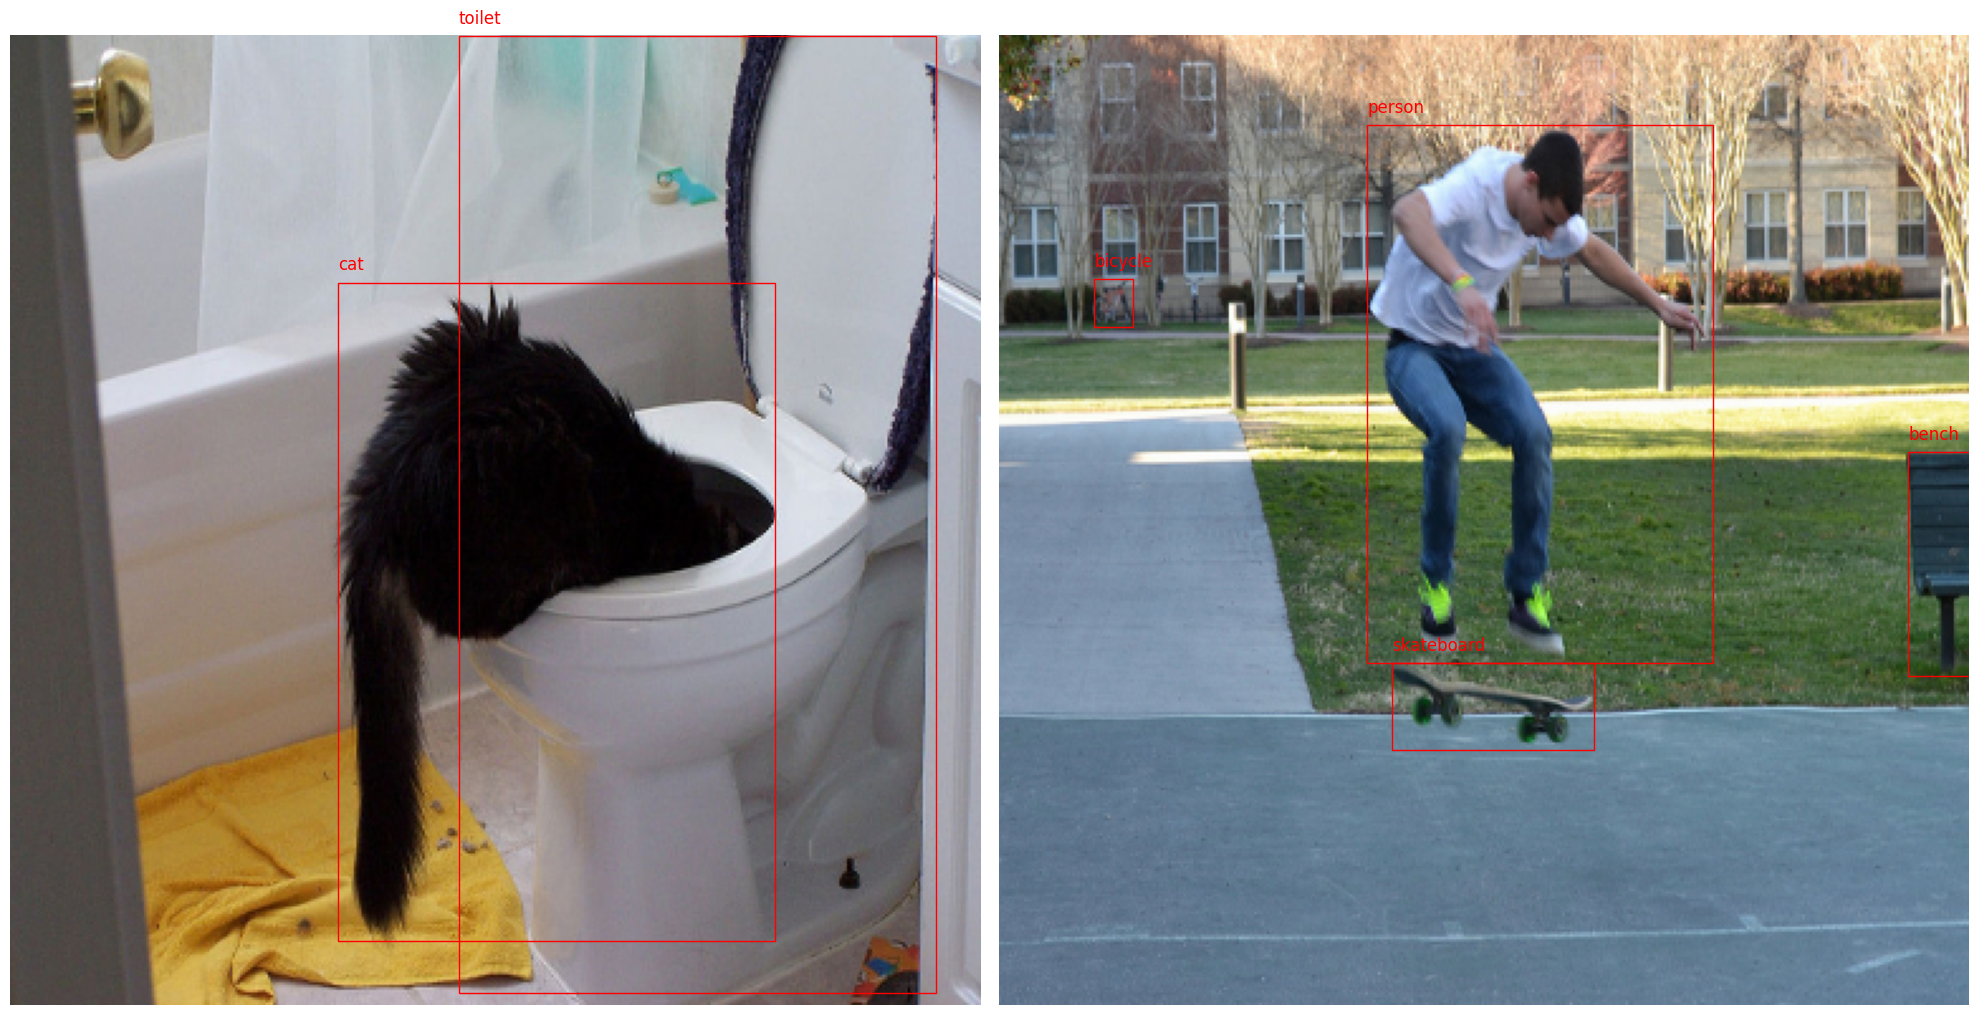

In [8]:
from utils.data_utils import show_img_with_bbox
import matplotlib.pyplot as plt
import numpy as np
import torchvision.transforms as T
from PIL import Image

dataset = dataloader.dataset
# Get original dataset from dataset if Subset is used
if hasattr(dataset, "dataset"):
    dataset = dataset.dataset

class_id_to_name = dataset.index_to_cat_name

#print(example_batch)

#fig, ax = plt.subplots()   
axes = show_img_with_bbox(batch, dataset, figsize=(10,10))


In [9]:
from model.model import VisionLanguageModel
model = VisionLanguageModel(
    config=config,
    image_token_index=processor.image_token_index,
    num_new_tokens=len(processor.special_tokens),
    do_init=True,
    initializers=processor.special_tokens_initializer
    )

You are using a model of type llava to instantiate a model of type llava_qwen. This is not supported for all configurations of models and can yield errors.
Sliding Window Attention is enabled but not implemented for `sdpa`; unexpected results may be encountered.


Loading vision tower: google/siglip-so400m-patch14-384


In [10]:
processor.tokenizer.batch_decode(batch["input_ids"], skip_special_tokens=True)

["system\nYou are a helpful assistant.\nuser\n\nDetect all objects in the image and output ONLY a valid JSON array of objects. Each object must have a 'class' (string name) and 'bbox' (list of 4 special coordinate tokens). Format: [{'class': 'person', 'bbox': ['<coord_2>', '<coord_3>', '<coord_5>', '<coord_8>']}, {'class': 'car', 'bbox': ['<coord_6>', '<coord_7>', '<coord_9>', '<coord_9>']}]. Each <coord_X> token represents a quantized position. Include all visible objects, even if partially visible. Output nothing but the JSON array.\nassistant\n",
 "system\nYou are a helpful assistant.\nuser\n\nDetect all objects in the image and output ONLY a valid JSON array of objects. Each object must have a 'class' (string name) and 'bbox' (list of 4 special coordinate tokens). Format: [{'class': 'person', 'bbox': ['<coord_2>', '<coord_3>', '<coord_5>', '<coord_8>']}, {'class': 'car', 'bbox': ['<coord_6>', '<coord_7>', '<coord_9>', '<coord_9>']}]. Each <coord_X> token represents a quantized posi

In [11]:
str_special_tokens = "<coord_0><coord_1>"
tokenizer.encode(str_special_tokens, add_special_tokens=False)

[151647, 151648]

In [12]:
classes_str = [["class1"], ["class2"]]
normalized_bbox = [[0.08, 0.1, 0.9, 0.9], [0.11, 0.4, 0.6, 0.7]]
processor.format_bbox_to_string(classes_str, normalized_bbox)

[{'class': ['class1'],
  'bbox': ['<coord_7>', '<coord_9>', '<coord_89>', '<coord_89>']},
 {'class': ['class2'],
  'bbox': ['<coord_10>', '<coord_39>', '<coord_59>', '<coord_69>']}]

In [13]:
#state_dict_model = model.state_dict()
#model.load_state_dict(state_dict_model)

In [14]:
device=torch.device("cpu")
state_dict = torch.load("../../checkpoints-trained/" + MODEL_NAME, map_location=device)
model.load_state_dict(state_dict.get("model_state_dict"))

([], [])

In [15]:
with np.printoptions(threshold=np.inf):
    #print(batch["input_ids"][0].numpy())
    print(tokenizer.decode(batch["input_ids"][0].numpy()))
    #print(batch["attention_mask"][0].numpy())

tokenizer.batch_decode(batch["input_ids"], skip_special_tokens=True)

<|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|im_start|>system
You are a helpful assistant.<|im_end|>
<|im_start|>user
<image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><ima

["system\nYou are a helpful assistant.\nuser\n\nDetect all objects in the image and output ONLY a valid JSON array of objects. Each object must have a 'class' (string name) and 'bbox' (list of 4 special coordinate tokens). Format: [{'class': 'person', 'bbox': ['<coord_2>', '<coord_3>', '<coord_5>', '<coord_8>']}, {'class': 'car', 'bbox': ['<coord_6>', '<coord_7>', '<coord_9>', '<coord_9>']}]. Each <coord_X> token represents a quantized position. Include all visible objects, even if partially visible. Output nothing but the JSON array.\nassistant\n",
 "system\nYou are a helpful assistant.\nuser\n\nDetect all objects in the image and output ONLY a valid JSON array of objects. Each object must have a 'class' (string name) and 'bbox' (list of 4 special coordinate tokens). Format: [{'class': 'person', 'bbox': ['<coord_2>', '<coord_3>', '<coord_5>', '<coord_8>']}, {'class': 'car', 'bbox': ['<coord_6>', '<coord_7>', '<coord_9>', '<coord_9>']}]. Each <coord_X> token represents a quantized posi

In [16]:
prompt1 = "Detect all objects in the image and output ONLY a valid JSON array of objects. Each object must have a 'class' (string name) and 'bbox' (normalized coordinates [x_min, y_min, x_max, y_max] between 0 and 1). Format: [{'class': 'person', 'bbox': [0.2, 0.3, 0.5, 0.8]}, {'class': 'car', 'bbox': [0.6, 0.7, 0.9, 0.95]}]. Include all visible objects, even if partially visible. Output nothing but the JSON array."
prompt2 = "Detect all objects in the image and output ONLY a valid JSON array of objects. Each object must have a 'class' (string name) and 'bbox' (list of 4 special coordinate tokens describing [x_min, y_min, x_max, y_max]). Format: [{'class': 'person', 'bbox': ['<coord_2>', '<coord_3>', '<coord_5>', '<coord_8>']}, {'class': 'car', 'bbox': ['<coord_6>', '<coord_7>', '<coord_9>', '<coord_9>']}]. Each <coord_X> token represents a quantized position. Include all visible objects, even if partially visible. Output nothing but the JSON array."
# len of new prompt 2 with special tokens shorter than prompt 1, even tough string is longer
len(tokenizer.encode(prompt1)), len(tokenizer.encode(prompt2))

(134, 129)

In [34]:
# Load Model with pretrained projection layer
from utils.train_utils import JSONStoppingCriteria
model.eval()
# TODO: use val set, so info bout bbox is not in input_ids, check if image tokens are filled with image info

outputs = model.generate(
    input_ids=batch["input_ids"].to(device),
    attention_mask=batch["attention_mask"].to(device),
    image=batch["images"].to(device),
    stopping_criteria=[JSONStoppingCriteria(processor.tokenizer)],
    do_sample=True,
    temperature=.9,
    top_p = 0.9,
    top_k = 100,
)

# Decode predictions
generated_text, predicted_boxes = processor.postprocess_json_batch(outputs, dataset, device)


predicted_boxes, generated_text

([{'boxes': tensor([], size=(0, 4)),
   'labels': tensor([], dtype=torch.int64),
   'scores': tensor([])},
  {'boxes': tensor([], size=(0, 4)),
   'labels': tensor([], dtype=torch.int64),
   'scores': tensor([])}],
 ['[{"class": "cat", "bbox": ["ตุ", "�", "เข้าร่วม", "รู้ส"]}, {"class": "toilet", "bbox": ["วิ", " BCHP", "ร์", "ศึก"]}]',
  '[{"class": "skateboard", "bbox": ["�", "สล็อต", " của", "�"]}, {"class": "bench", "bbox": ["<coord_6>", "ใหญ่", "วันที่", "ด์"]}, {"class": "person", "bbox": ["螺", "塚", "靈", "ก้าว"]}]'])

In [18]:
batch["bbox_str"]

['[{"class": "toilet", "bbox": ["<coord_45>", "<coord_0>", "<coord_94>", "<coord_97>"]}, {"class": "cat", "bbox": ["<coord_33>", "<coord_25>", "<coord_77>", "<coord_92>"]}]',
 '[{"class": "skateboard", "bbox": ["<coord_39>", "<coord_63>", "<coord_60>", "<coord_72>"]}, {"class": "person", "bbox": ["<coord_37>", "<coord_9>", "<coord_72>", "<coord_64>"]}, {"class": "bicycle", "bbox": ["<coord_9>", "<coord_24>", "<coord_13>", "<coord_29>"]}, {"class": "bench", "bbox": ["<coord_92>", "<coord_42>", "<coord_99>", "<coord_65>"]}]']

[{'boxes': tensor([], size=(0, 4)), 'labels': tensor([], dtype=torch.int64), 'scores': tensor([])}, {'boxes': tensor([], size=(0, 4)), 'labels': tensor([], dtype=torch.int64), 'scores': tensor([])}]


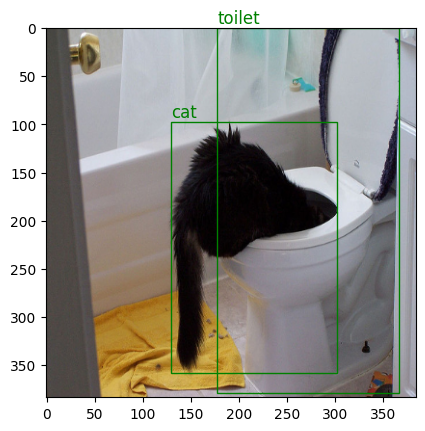

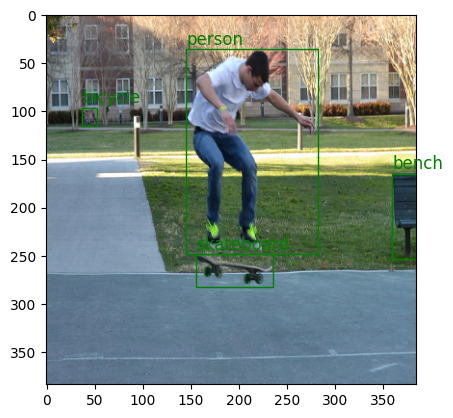

In [19]:
# Plot predicted boxes, target boxes and labels on images
id_to_cat_name = dataset.index_to_cat_name
print(predicted_boxes)

#predicted_boxes = [{"class": [1, 32], "bbox": [[0.4879453125, 0.6142578125, 0.6474609375, 0.814453125], [0.0, 0.0, 0.99951171875, 0.9990234375]]}]

for i in range(len(batch["images"])):
    fig, ax = plt.subplots()

    img, bboxes, categories = batch["images"][i], predicted_boxes[i]["boxes"], predicted_boxes[i]["labels"]

    img = img.permute(1, 2, 0).numpy()
    img = img - img.min()
    img = img / img.max()
    ax.imshow(img)

    for cat, bbox in zip(categories, bboxes):
        # print(bbox)
        x1, y1, x2, y2 = bbox # x_min, y_min, x_max, y_max -> YOLO format
        # x1, y1, x2, y2 = x1*img.shape[1], y1*img.shape[0], x2*img.shape[1], y2*img.shape[0] 
        rect = plt.Rectangle((x1, y1), x2-x1, y2-y1, linewidth=1, edgecolor="r", facecolor="none")
        ax.add_patch(rect)
        
        # add label text to rect
        if cat.item() in id_to_cat_name:
            class_name = id_to_cat_name[cat.item()] #no .item()
        else:
            class_name = "Unknown"
        ax.text(x1, y1-5, class_name, fontsize=12, color="red")

    corr_boxes, corr_labels = batch["instance_bboxes"][i], batch["instance_classes_id"][i]

    for cat, bbox in zip(corr_labels, corr_boxes):
        x1, y1, x2, y2 = bbox
        x1, y1, x2, y2 = (
                x1 * img.shape[1],
                y1 * img.shape[0],
                x2 * img.shape[1],
                y2 * img.shape[0],
            )
        rect = plt.Rectangle((x1, y1), x2-x1, y2-y1, linewidth=1, edgecolor="g", facecolor="none")
        ax.add_patch(rect)
        
        # add label text to rect
        if cat.item() in id_to_cat_name:
            class_name = id_to_cat_name[cat.item()]
        ax.text(x1, y1-5, class_name, fontsize=12, color="green")
    
    plt.show()

## Test Train Metrics

In [20]:
# Calculate test metrics
from utils.train_metrics import TrainMetrics
device = "cpu"
metrics = TrainMetrics(device=device)


target_boxes = processor.postprocess_target_batch(batch, device)

metrics.update(
    predicted_boxes=predicted_boxes,
    target_boxes=target_boxes,
    target_texts=batch["bbox_str"],
    generated_text=generated_text,
)
metrics.compute()

{'map': 0.0,
 'map_50': 0.0,
 'map_75': 0.0,
 'bleu_score': 0.06939140113718371,
 'meteor_score': 0.4365656523175691}

In [21]:
pred_boxes_test = [{
        'boxes': torch.tensor([[183.7680,  92.0112, 332.6478, 226.5556], [169.6680,   5.6480, 324.7800, 377.7072]]), 
        'labels': torch.tensor([17, 70]), 
        'scores': torch.tensor([1., 1.])
    }, 
    {
        'boxes': torch.tensor([[305.1480, 223.1204, 320.6880, 235.3108], [ 73.9140,  37.1321, 219.9680, 262.9113]]),
        'labels': torch.tensor([15,  1]), 
        'scores': torch.tensor([1., 1.])
    }]
target_boxes_test = [{
        'boxes': torch.tensor([[169.6680,   5.6480, 324.7800, 377.7072], [225.7680,  92.0112, 332.6478, 226.5556]]), 
        'labels': torch.tensor([70, 17]), 
        'scores': torch.tensor([1., 1.])
    }, 
    {
        'boxes': torch.tensor([[305.1480, 223.1204, 320.6880, 235.3108], [ 73.9140,  37.1321, 219.9680, 262.9113]]),
        'labels': torch.tensor([15,  1]), 
        'scores': torch.tensor([1., 1.])
    }]

test_metrics = TrainMetrics(device=device)
test_metrics.update(predicted_boxes=pred_boxes_test, target_boxes=target_boxes_test, target_texts=batch["bbox_str"], generated_text=generated_text)
test_metrics.compute()

{'map': 0.875,
 'map_50': 1.0,
 'map_75': 0.75,
 'bleu_score': 0.06939140113718371,
 'meteor_score': 0.4365656523175691}

## Else

In [22]:
from utils.train_utils import build_train_dataloader

train_dataloader = build_train_dataloader(config, processor)
batch_train = next(iter(train_dataloader))
len(train_dataloader)

loading annotations into memory...
Done (t=4.00s)
creating index...
index created!


118287

In [23]:
processor.tokenizer.batch_decode(batch_train["input_ids"], skip_special_tokens=True)

['system\nYou are a helpful assistant.\nuser\n\nDetect all objects in the image and output ONLY a valid JSON array of objects. Each object must have a \'class\' (string name) and \'bbox\' (list of 4 special coordinate tokens). Format: [{\'class\': \'person\', \'bbox\': [\'<coord_2>\', \'<coord_3>\', \'<coord_5>\', \'<coord_8>\']}, {\'class\': \'car\', \'bbox\': [\'<coord_6>\', \'<coord_7>\', \'<coord_9>\', \'<coord_9>\']}]. Each <coord_X> token represents a quantized position. Include all visible objects, even if partially visible. Output nothing but the JSON array.\nassistant\n[{"class": "person", "bbox": ["<coord_17>", "<coord_4>", "<coord_54>", "<coord_97>"]}, {"class": "cell phone", "bbox": ["<coord_46>", "<coord_79>", "<coord_51>", "<coord_81>"]}, {"class": "remote", "bbox": ["<coord_45>", "<coord_78>", "<coord_51>", "<coord_80>"]}, {"class": "tie", "bbox": ["<coord_40>", "<coord_40>", "<coord_51>", "<coord_92>"]}]']

In [24]:
if torch.all(batch_train["labels"] == -100):
    print("All labels are -100")
batch_train["labels"]

tensor([[-100, -100, -100,  ..., -100, -100, -100]])

In [39]:
tokenizer.encode("position 0.1, <coord_1>", add_special_tokens=False)

[3487, 220, 15, 13, 16, 11, 220, 151648]

In [25]:
processor.tokenizer.decode(batch_train["labels"][batch_train["labels"] != -100])

'[{"class": "person", "bbox": ["<coord_17>", "<coord_4>", "<coord_54>", "<coord_97>"]}, {"class": "cell phone", "bbox": ["<coord_46>", "<coord_79>", "<coord_51>", "<coord_81>"]}, {"class": "remote", "bbox": ["<coord_45>", "<coord_78>", "<coord_51>", "<coord_80>"]}, {"class": "tie", "bbox": ["<coord_40>", "<coord_40>", "<coord_51>", "<coord_92>"]}]<|im_end|>'

In [26]:
processor.tokenizer.encode("<coord_0>left0.1111", add_special_tokens=True)

[151647, 2359, 15, 13, 16, 16, 16, 16]

In [27]:
forward_output = model.forward(
    input_ids=batch["input_ids"].to(device), 
    attention_mask=batch["attention_mask"].to(device), 
    images=batch["images"].to(device))

In [28]:
processor.tokenizer.batch_decode(forward_output.logits.argmax(dim=-1))

['/INFO/INFO/INFO/INFO/INFO/INFO/INFO/INFO/INFO/INFO/INFO/INFO/INFO/INFO/INFO/INFO/INFO/INFO/INFO/INFO/INFO/INFO/INFO/INFO/INFO/INFO/INFO/INFO/INFO/INFO/INFO,\n\n\n\n\nimport are an teacher assistant\n\n<|im_end|>\n<|im_start|>assistant\n<|im_end|> /sink,断裂 universal\n在线在线 Wins station\n\n,\n,oul plant of at,\n**\n\n. with are of,.\n,,.\n断裂 measuring\n industry\n\n pool,*在线\n at\n, an\t在线 a in, industry断裂,*\n,^...\n.\n industry,,在线\n at\n靶\n\n with, with\t,\t, in断裂itol a at / industry /,\n在线 station,在线 in at at, at industry.\n\n\t industry,露天oul\n\n tub or at pool on tub /, with marksoul station station /\n, onoul. industry, with a       露天脲连锁\n在线")\n\n.在线 scene在线 station{} with is at are\n\n on,\n\n在线在线^")\n a露天 \n断裂]\n\n\n断裂 are)\n ( pool a with")\n\n\n with tub tub在线 a\n a with with| at station /在线 in atitol water    pool在线 pool cat^|\n at at station of at^ | is industry with station it on断裂 a\nitol\n at tub station of\n\n are are|\n cat on / station a\n with在线\n\n\n|在线( cat a of^在线